# Code for fitting DATA = a*QCD + b*VBF
## Diego Baron

## 1. First, import the plotter and iminuit libraries. The second part creates a 2D least square fit function.

In [153]:
# basic setup of the notebook
from matplotlib import pyplot as plt
import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
#from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)


############ Create a 2D least square fit ###################

from iminuit.util import describe, make_func_code
class LeastSquares:
    """
    Generic least-squares cost function with error.
    """

    errordef = Minuit.LEAST_SQUARES # for Minuit to compute errors correctly

    def __init__(self, model, s1, s2, y, err):
        self.model = model  # model predicts y for given x
        self.s1 = np.asarray(s1)
        self.s2 = np.asarray(s2)
        self.y = np.asarray(y)
        self.err = np.asarray(err)

    def __call__(self, *par):  # we accept a variable number of model parameters
        ym = self.model(self.s1,self.s2, *par)
        return np.sum((self.y - ym) ** 2 / self.err ** 2)
    
class BetterLeastSquares(LeastSquares):
    def __init__(self, model, s1 , s2, y, err):
        super().__init__(model, s1,s2 , y, err)
        self.func_code = make_func_code(describe(model)[2:])

iminuit version: 2.18.0


## Configuring the FIT
### Select which samples to use for the BG and Signal,
### comment out last line for Z->tau tau final state. 

In [166]:
path_to_root_files = "/Users/diegomac/Documents/HEP/VBF-Analysis/Zee/Plots/ABCD/SR/"
histogram = "mass_jj"

QCD_sample = 'Zee_SherpaRW.root'
VBF_sample = 'Signal_PoPy.root'

BG_samples = ['Wjets.root','singletop.root','VV.root','ttbar.root']
BG_Tau = ['Higgs.root','Zjets.root']
#BG_samples += BG_Tau

Unpack the histograms and plot the relevant shapes

In [167]:
import os
import ROOT as r
import ctypes
import pandas as pd
import numpy as np

def biner(edges,bin_widths,histogram):
    if (len(edges)+1!=len(bin_widths)):
        print("Check edges and bin widths array sizes!")
        return
    
    bins=[]
    first_bin = histogram.GetXaxis().GetBinLowEdge(1)
    print(first_bin)
    last_bin = histogram.GetXaxis().GetBinUpEdge(histogram.GetNbinsX())
    print(last_bin)
    for i in range(0,len(edges)):
        n_spaces = int((edges[i] - first_bin)/bin_widths[i])
        bins = np.concatenate((bins,np.linspace(first_bin,edges[i],n_spaces,endpoint=False)))
        first_bin = edges[i]
        if edges[i]==edges[-1]:
            n_spaces = int((last_bin - edges[i])/bin_widths[i+1])
            bins = np.concatenate((bins,np.linspace(edges[i],last_bin,n_spaces,endpoint=False)))
            bins = np.concatenate((bins,[last_bin]))
    return bins

def normalization(hist_list,norm_bin):
    for hist in hist_list:
        for i in range(1,hist.GetNbinsX()+1):
            value=hist.GetBinContent(i)
            error=hist.GetBinError(i)
            sf=hist.GetBinWidth(i)/norm_bin
            hist.SetBinContent(i,value/sf)
            hist.SetBinError(i,error/sf)
            
def Unpack_Histo(histogram_file):
    bin_content = []
    bin_content_uncer =[]
    for i in range(2,histogram_file.GetNbinsX()+1):
        bin_content.append(histogram_file.GetBinContent(i))
        bin_content_uncer.append(histogram_file.GetBinError(i))
    return np.array(bin_content),np.array(bin_content_uncer)

############# DATA SUBTRACTION #######################

#r.TH1.SetDefaultSumw2()

data_file = r.TFile.Open(path_to_root_files+'Data.root')
data_hist = data_file.Get(histogram)
data_hist.SetDirectory(0)

s=data_hist.GetXaxis().GetBinLowEdge(1)
e=data_hist.GetXaxis().GetBinUpEdge(data_hist.GetNbinsX())
rebining=biner([1500,3000],[250,500,1000],data_hist)
nb=len(rebining)-1
data_hist=data_hist.Rebin(nb,"data",rebining)


for i in BG_samples:
    file = r.TFile.Open(path_to_root_files+i)
    bg_sample = file.Get(histogram)
    bg_sample = bg_sample.Rebin(nb,"bg",rebining)
    data_hist.Add(bg_sample,-1)
    file.Close()

############# VBF AND QCD HISTOGRAM SET UP #########################

QCD_file = r.TFile.Open(path_to_root_files+QCD_sample)
QCD_hist = QCD_file.Get(histogram)
QCD_hist.SetDirectory(0)
QCD_hist=QCD_hist.Rebin(nb,"QCD",rebining)

VBF_file = r.TFile.Open(path_to_root_files+VBF_sample)
VBF_hist = VBF_file.Get(histogram)
VBF_hist.SetDirectory(0)
VBF_hist=VBF_hist.Rebin(nb,"VBF",rebining)

################### NORMALISING SHAPES #####################

normalization([data_hist,QCD_hist,VBF_hist],250)
#normalization([data_hist,VBF_hist],250)

############## UNPACKING THE HISTOGRAMS INTO NUMPY ARRAYS ################

data_shape, data_shape_uncer = Unpack_Histo(data_hist)
qcd_shape, qcd_shape_uncer = Unpack_Histo(QCD_hist)
vbf_shape, vbf_shape_uncer = Unpack_Histo(VBF_hist)

total_uncer = np.sqrt(data_shape_uncer**2+vbf_shape_uncer**2+qcd_shape_uncer**2)

x_bins = np.array([data_hist.GetBinLowEdge(i) for i in range(2,data_hist.GetNbinsX()+1)])

#data_shape[7]=vbf_shape[7]+qcd_shape[7]


index=0
for i in range(len(data_shape)):
    if data_shape[i]<0:
    #if i==7:
        break
    index+=1

def correct_shape(vector,index):
    return vector[0:index]

data_shape = correct_shape(data_shape,index)
qcd_shape = correct_shape(qcd_shape,index)
vbf_shape = correct_shape(vbf_shape,index)
data_shape_uncer = correct_shape(data_shape_uncer,index)
qcd_shape_uncer = correct_shape(qcd_shape_uncer,index)
vbf_shape_uncer = correct_shape(vbf_shape_uncer,index)
x_bins = correct_shape(x_bins,index)
total_uncer = correct_shape(total_uncer,index)

print("x = ",x_bins)
print("y = ",data_shape)
print("QCD_shape = ",qcd_shape)
print("QCD error = ",qcd_shape_uncer)
print("% QCD error ", 100*qcd_shape_uncer/qcd_shape)

0.0
5000.0
x =  [ 250.  500.  750. 1000. 1250. 1500. 2000. 2500. 3000. 4000.]
y =  [4185.50634766 3123.19848633 1568.10852051  760.63275146  458.01507568
  217.75387573   98.37812805   29.81842613   14.70673752    4.74141407]
QCD_shape =  [4.23532910e+03 2.86682324e+03 1.21683240e+03 5.37518372e+02
 2.55368866e+02 1.01134552e+02 3.34974976e+01 1.34227581e+01
 5.55640554e+00 1.36254370e+00]
QCD error =  [52.84948448 36.56056041 17.55981133 10.83872176  6.40811164  3.21005034
  1.5152404   0.8273039   0.53980941  0.19234433]
% QCD error  [ 1.24782474  1.27529873  1.44307559  2.01643745  2.50935509  3.17403921
  4.52344356  6.16344192  9.71508297 14.11656257]


## 2. Include full uncertainties on the fit (This is for the standard ABCD method)
### Calculation for the total uncertainties, including the re-weighting function.
<img src="Weight-Uncertainty.jpg" width=800 height=800 />

In [168]:
### Including the full uncertainties for the Standard ABCD #######

SF_sherpa = np.array([1.191947493608173, 1.0533849781514475, 0.9327344771000723, 0.829883020868467, 0.7448314828267345, 0.6511154483110894, 0.5930844551100937, 0.6242695391061465, 0.9092022336795254, 2.0082758450131486])
SF_sherpa_error =  np.array([0.024832248231732006, 0.02084994016932095, 0.025121873748490012, 0.03044693638877294, 0.03552656783662926, 0.04718166410747222, 0.08599269229591437, 0.17230228380603985, 0.5080358588861151, 2.167147164603685])

SF_mg =  np.array([0.7501716556638925, 0.6553409014338234, 0.5796489788329213, 0.5223969542591113, 0.48259319793002875, 0.4528394974758118, 0.461872031268506, 0.5186567944044667, 0.6895118832931821, 1.1046475273074001])
SF_mg_error =  np.array([0.017676865198085482, 0.01625302419125153, 0.02046071985681315, 0.024282779020102764, 0.028892515734035038, 0.04453963821747093, 0.09465078627174732, 0.19072927442291143, 0.45053134703576314, 1.0497978531225711])

SF = correct_shape(SF_sherpa,index)
SF_error = correct_shape(SF_sherpa_error,index)

qcd_shape_uncer = np.sqrt(qcd_shape_uncer**2+((SF_error/SF)**2)*qcd_shape_uncer**2) 

total_uncer = np.sqrt(data_shape_uncer**2+vbf_shape_uncer**2+qcd_shape_uncer**2)

print("QCD_shape = ",qcd_shape)
print("QCD error = ",qcd_shape_uncer)
print("% QCD error = ", 100*qcd_shape_uncer/qcd_shape)
print("% SF error = ", 100*SF_error/SF)

QCD_shape =  [4.23532910e+03 2.86682324e+03 1.21683240e+03 5.37518372e+02
 2.55368866e+02 1.01134552e+02 3.34974976e+01 1.34227581e+01
 5.55640554e+00 1.36254370e+00]
QCD error =  [52.86095232 36.56772144 17.56617927 10.8460139   6.41539687  3.21846706
  1.53108483  0.85823736  0.61836459  0.28297995]
% QCD error =  [ 1.24809551  1.27554852  1.44359891  2.01779408  2.51220792  3.18236152
  4.57074392  6.39389726 11.12885993 20.76850427]
% SF error =  [  2.08333407   1.97932765   2.69335747   3.66882267   4.76974573
   7.2462824   14.4992322   27.60062329  55.87710193 107.91083157]


# OPTIONAL : Just for the average of MCs
## Average with fit uncertainties
### 1. Define the files, histogram and channel to average.
### 2. Load files, rebin and normalise the histograms.
### 3. Unpack the histograms in arrays and add the re-weight uncertainties to the yields.
### 4. Average and calculate total uncertainty.

0.0
5000.0
MG =  4048.244384765625 Sherpa =  4205.681640625 Avrg =  4110.671369675919
MG =  2980.739501953125 Sherpa =  2846.755615234375 Avrg =  2922.981247588715
MG =  1282.91064453125 Sherpa =  1208.3145751953125 Avrg =  1242.3762679088284
MG =  579.3735961914062 Sherpa =  533.7557373046875 Avrg =  554.4249194647268
MG =  272.3138732910156 Sherpa =  253.58128356933594 Avrg =  261.59059556319164
MG =  106.61859130859375 Sherpa =  100.42660522460938 Avrg =  103.71451744782844
MG =  38.31074905395508 Sherpa =  33.26301574707031 Avrg =  35.05642011291166
MG =  17.986175537109375 Sherpa =  13.3287992477417 Avrg =  14.18079658509966
MG =  5.783628940582275 Sherpa =  5.517510890960693 Avrg =  5.622372229479005
MG =  1.3411449193954468 Sherpa =  1.3530058860778809 Avrg =  1.3500918628657346

 Uncertainties

MG =  42.54858611461818 Sherpa =  52.4909256545564 Avrg =  33.053439301704714
MG =  31.608483509779106 Sherpa =  36.31174738994652 Avrg =  23.841187978084154
MG =  19.028528058572334 She

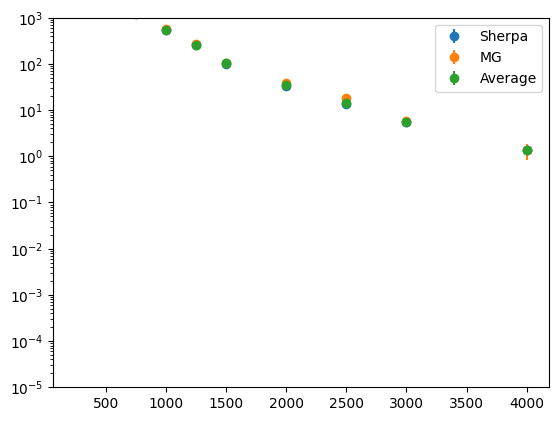

In [170]:
path_to_root_files = "/Users/diegomac/Documents/HEP/VBF-Analysis/Zee/Plots/ABCD/SR/"
histogram = "mass_jj"
channel = "Zee"
a_SHERPA = 0.993
a_MG = 1.035

SHERPA_FILE = r.TFile.Open(path_to_root_files+channel+'_SherpaRW.root')
MG_FILE = r.TFile.Open(path_to_root_files+channel+'_MGRW.root')

SHERPA_HISTO = SHERPA_FILE.Get(histogram)
MG_HISTO = MG_FILE.Get(histogram)

SHERPA_HISTO.Scale(a_SHERPA)
MG_HISTO.Scale(a_MG)

rebining=biner([1500,3000],[250,500,1000],MG_HISTO)
nb=len(rebining)-1
SHERPA_HISTO=SHERPA_HISTO.Rebin(nb,"data",rebining)
MG_HISTO=MG_HISTO.Rebin(nb,"data",rebining)
normalization([SHERPA_HISTO,MG_HISTO],250)

SHERPA, SHERPA_E = Unpack_Histo(SHERPA_HISTO)
MG,MG_E = Unpack_Histo(MG_HISTO)


SHERPA_E = np.sqrt(SHERPA_E**2+((SF_sherpa_error/SF_sherpa)**2)*SHERPA_E**2) 
MG_E = np.sqrt(MG_E**2+((SF_mg_error/SF_mg)**2)*MG_E**2) 

SHERPA_NORM, MG_NORM = SHERPA.sum(),MG.sum()

#SHERPA, MG = SHERPA/SHERPA_NORM, MG/MG_NORM
#SHERPA_E, MG_E = SHERPA_E/SHERPA_NORM, MG_E/MG_NORM

WEIGHT = (1/SHERPA_E**2 + 1/MG_E**2)
AVERAGE = (SHERPA/SHERPA_E**2+MG/MG_E**2)/WEIGHT
AVERAGE_E = np.sqrt(1/WEIGHT)

qcd_shape = AVERAGE
qcd_shape_uncer = AVERAGE_E

total_uncer = np.sqrt(data_shape_uncer**2+vbf_shape_uncer**2+qcd_shape_uncer**2)

### DRAW THE SHAPES AND THE AVERAGE

plt.errorbar(x_bins, SHERPA,SHERPA_E, fmt="o",label='Sherpa');
plt.errorbar(x_bins, MG, MG_E, fmt="o",label='MG');
plt.errorbar(x_bins, AVERAGE, AVERAGE_E, fmt="o",label='Average');
plt.legend()
plt.ylim(0.00001,1000)
plt.yscale("log")

for i in range(0,len(AVERAGE)):
    print('MG = ',MG[i],'Sherpa = ',SHERPA[i], 'Avrg = ', AVERAGE[i])

print('\n Uncertainties\n')    

for i in range(0,len(AVERAGE_E)):
    print('MG = ',MG_E[i],'Sherpa = ',SHERPA_E[i], 'Avrg = ', AVERAGE_E[i])
    
print('\n SHERPA - MG + Uncertainty \n')    

for i in range(0,len(AVERAGE_E)):
    print(SHERPA[i]-MG[i], '+-', np.sqrt(SHERPA_E[i]**2 + MG_E[i]**2))

# OPTIONAL : Alternative ABCD Method

In [9]:
#CRa Old
#scaling_factors_sherpa = np.array([1.46753645, 1.10726058, 0.91471666, 0.78389782, 0.69573116, 0.62993467, 0.52442706, 0.45806327, 0.35676283, 0.30835927])
#scaling_factors_mg = np.array([1.36794531, 1.09241414, 0.89026988, 0.78009623, 0.62210596,0.62110871, 0.5857293 , 0.7745406 , 0.59778947, 0.68026555])
#sherpa_err = np.array([0.02151203, 0.02010888, 0.01628109, 0.01626265, 0.01860157, 0.02868193, 0.02134186, 0.06148216, 0.05134512, 0.05997645])
#mg_err = np.array([0.02012357, 0.01491411, 0.01571727, 0.01953574, 0.06264988, 0.02268164, 0.03665924, 0.07321661, 0.07261506, 0.27062507])
#scaling_factors_average = (scaling_factors_sherpa/sherpa_err**2+scaling_factors_mg/mg_err**2)/(1/sherpa_err**2+1/mg_err**2)

scaling_factors_mg = np.array([0.93341933, 1.09575077, 1.10380183, 1.14542872, 1.01003097, 1.03616701, 1.38178206, 2.15901377, 2.97026279, 1.91803383])
scaling_factors_sherpa = np.array([0.98769515, 1.06635816, 1.14465136, 1.226041  , 1.19181199, 1.10837077, 1.41706321, 0.99935805, 1.46043103, 0.84654533])
mg_err = np.array([0.02697306, 0.03203529, 0.04424594, 0.06454911, 0.12967055, 0.09166941, 0.23436328, 0.70292785, 1.07097145, 1.7067704 ])
sherpa_err = np.array([0.02818704, 0.03151608, 0.04191588, 0.06225261, 0.07803288, 0.0778964 , 0.14497813, 0.18114561, 0.44862734, 0.47001628])
scaling_factors_average = (scaling_factors_sherpa/sherpa_err**2+scaling_factors_mg/mg_err**2)/(1/sherpa_err**2+1/mg_err**2)


""" #CRc
scaling_factors_sherpa = np.array([0.91018349, 0.90782344, 0.96345472, 1.12878442, 1.32670617, 1.5572598 , 2.09448314, 3.21974707, 3.58671308, 5.10975885])
scaling_factors_mg = np.array([ 0.83782703,  0.94988137,  1.07373536,  1.27226925,  1.30644107, 1.6539005 ,  2.41354036,  3.96563172,  4.55003881, 14.47130203])
sherpa_err = np.array([0.01291131, 0.01214627, 0.01783098, 0.03048616, 0.04186164, 0.06440318, 0.09821029, 0.4554642 , 0.32892466, 0.94089577])
mg_err = np.array([0.00914283, 0.01150731, 0.01728026, 0.03127507, 0.04845319, 0.07180173, 0.18259241, 0.47656865, 0.81845578, 4.41446637])
scaling_factors_average = (scaling_factors_sherpa/sherpa_err**2+scaling_factors_mg/mg_err**2)/(1/sherpa_err**2+1/mg_err**2)
"""

qcd_shape_sherpa,qcd_shape_mg = np.zeros(len(qcd_shape)),np.zeros(len(qcd_shape))
qcd_shape_sherpa_err,qcd_shape_mg_err = np.zeros(len(qcd_shape)),np.zeros(len(qcd_shape))
for i in range(0,len(qcd_shape)):
    qcd_shape_sherpa[i]=qcd_shape[i]*scaling_factors_sherpa[i]
    qcd_shape_sherpa_err[i]=qcd_shape_sherpa[i]*((qcd_shape_uncer[i]/qcd_shape[i])**2+(sherpa_err[i]/scaling_factors_sherpa[i])**2)**0.5
    qcd_shape_mg[i]=qcd_shape[i]*scaling_factors_mg[i]
    qcd_shape_mg_err[i]=qcd_shape_mg[i]*((qcd_shape_uncer[i]/qcd_shape[i])**2+(mg_err[i]/scaling_factors_mg[i])**2)**0.5
print("x = ",x_bins)
print("y = ",data_shape)
print("QCD_shape = ",qcd_shape)
print("y_error = ",total_uncer)

x =  [ 250.  500.  750. 1000. 1250. 1500. 2000. 2500. 3000. 4000.]
y =  [9.86355273e+03 7.08558301e+03 3.51215747e+03 1.77503491e+03
 1.05968372e+03 4.89834564e+02 2.06214737e+02 8.40699081e+01
 3.26564980e+01 9.23526192e+00]
QCD_shape =  [8.13128223e+03 6.02481543e+03 2.85801514e+03 1.46131689e+03
 7.97229065e+02 3.61255951e+02 1.28621628e+02 5.48793945e+01
 1.52523870e+01 2.66394901e+00]
y_error =  [120.2464058   97.73971272  67.72482284  46.99127766  35.86842886
  20.0825357   10.87716692   9.58953307   3.00725284   1.58021603]


Text(0.5, 1.0, 'MG/SHERPA --- CRc ')

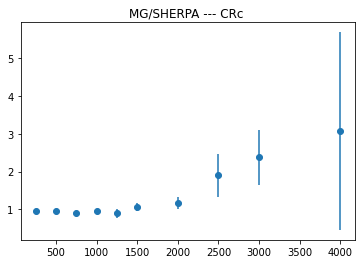

In [11]:
ratio=qcd_shape_mg/qcd_shape_sherpa
ratio_err=ratio*((qcd_shape_mg_err/qcd_shape_mg)**2+(qcd_shape_sherpa_err/qcd_shape_sherpa)**2)**0.5

plt.errorbar(x_bins,ratio,ratio_err,fmt="o")
#plt.yscale("log")
plt.title("MG/SHERPA --- CRc ")

## 3. Draw the Pre-Fit shapes

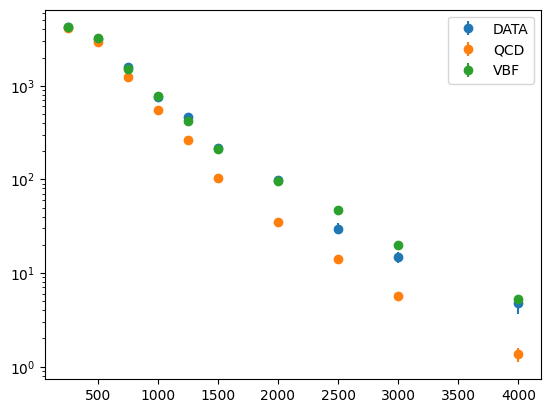

In [171]:

# our model, unicode parameter names are supported :)
def model(shape1,shape2, qcd, vbf):
    return qcd*shape1 + vbf*shape2


# generate random toy data with random offsets in y
x_axis = x_bins
y_axis = data_shape

### Normalise the mc samples

#qcd_shape = qcd_shape/qcd_shape.sum()
#vbf_shape = vbf_shape/vbf_shape.sum()


y_error = np.sqrt(data_shape_uncer**2+vbf_shape_uncer**2+qcd_shape_uncer**2)

# draw toy data
plt.errorbar(x_axis, y_axis,y_error, fmt="o",label='DATA');
plt.errorbar(x_axis, qcd_shape,qcd_shape_uncer, fmt="o",label='QCD');
plt.errorbar(x_axis, qcd_shape+vbf_shape,np.sqrt(vbf_shape_uncer**2+qcd_shape_uncer**2), fmt="o",label='VBF');
plt.legend()
#plt.ylim(0.1,1000)
plt.yscale("log")

## 4. Perform the Fit

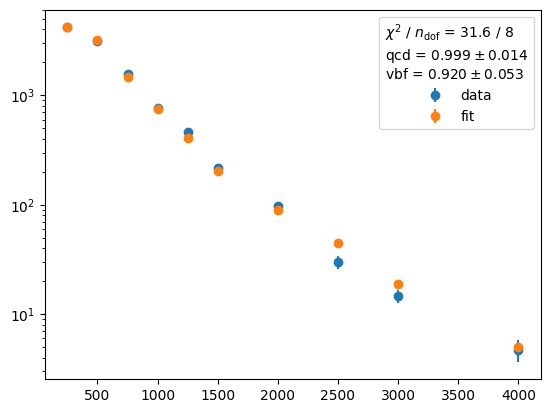

In [172]:
# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = BetterLeastSquares(model,qcd_shape,vbf_shape, data_shape,total_uncer)

m = Minuit(least_squares, qcd=1.0, vbf=1.0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# draw data and fitted line
plt.errorbar(x_axis, data_shape, total_uncer, fmt="o", label="data")
plt.errorbar(x_axis, model(qcd_shape,vbf_shape, *m.values),0,fmt="o", label="fit")
plt.yscale('log')

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x_axis) - m.nfit}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info));